## Group Name : PP Outliers
## Project Name : Why So Harsh!
## MT2022069 Parul Ghotikar
## MT2022071 Parv Parikh

IMPORTS Required

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer

import re
from nltk.corpus import stopwords 

from sklearn.feature_extraction.text import TfidfVectorizer

reading datasets

In [7]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89359 entries, 0 to 89358
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               89359 non-null  object
 1   text             89359 non-null  object
 2   harsh            89359 non-null  int64 
 3   extremely_harsh  89359 non-null  int64 
 4   vulgar           89359 non-null  int64 
 5   threatening      89359 non-null  int64 
 6   disrespect       89359 non-null  int64 
 7   targeted_hate    89359 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 5.5+ MB


# Data analysis

In [8]:
data_count=data.iloc[:,2:].sum()
data_count

harsh              8559
extremely_harsh     917
vulgar             4742
threatening         268
disrespect         4392
targeted_hate       802
dtype: int64

In [15]:
# Shows the count of 0s and 1s  
print(data.harsh.value_counts(normalize=True))
print(data.extremely_harsh.value_counts(normalize=True))
print(data.vulgar.value_counts(normalize=True))
print(data.threatening.value_counts(normalize=True))
print(data.disrespect.value_counts(normalize=True))
print(data.targeted_hate.value_counts(normalize=True))


0    0.904218
1    0.095782
Name: harsh, dtype: float64
0    0.989738
1    0.010262
Name: extremely_harsh, dtype: float64
0    0.946933
1    0.053067
Name: vulgar, dtype: float64
0    0.997001
1    0.002999
Name: threatening, dtype: float64
0    0.95085
1    0.04915
Name: disrespect, dtype: float64
0    0.991025
1    0.008975
Name: targeted_hate, dtype: float64


In [5]:
data.keys()

Index(['id', 'text', 'harsh', 'extremely_harsh', 'vulgar', 'threatening',
       'disrespect', 'targeted_hate'],
      dtype='object')

In [6]:
test.keys()

Index(['id', 'text'], dtype='object')

# Histogram plot for data analysis

<AxesSubplot:>

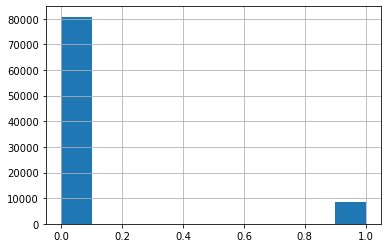

In [7]:
data['harsh'].hist()

<AxesSubplot:>

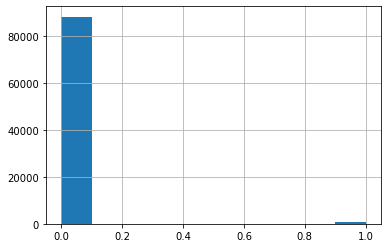

In [8]:
data['extremely_harsh'].hist()

<AxesSubplot:>

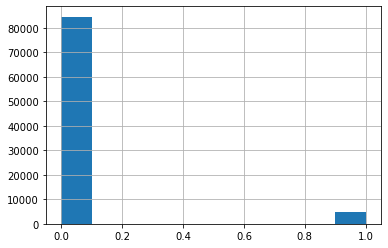

In [9]:
data['vulgar'].hist()

<AxesSubplot:>

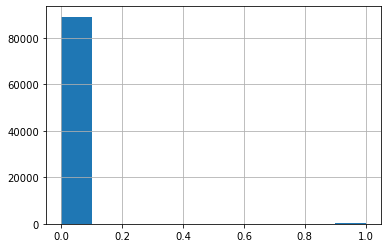

In [10]:
data['threatening'].hist()

<AxesSubplot:>

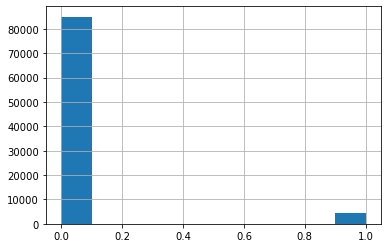

In [11]:
data['disrespect'].hist()

<AxesSubplot:>

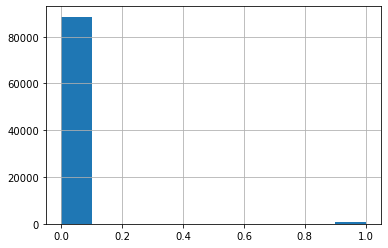

In [12]:
data['targeted_hate'].hist()

In [13]:
# checks for is null values

data.isnull().sum()

id                 0
text               0
harsh              0
extremely_harsh    0
vulgar             0
threatening        0
disrespect         0
targeted_hate      0
dtype: int64

In [14]:
# Calculating total of clean comments and comments with labels

rowSum = data.iloc[:,2:].sum(axis=1)
cleanComment = (rowSum==0).sum(axis=0)

print("Total comments = ",len(data))
print("clean comments = ",cleanComment)
print("comments with labels =",(len(data)-cleanComment))

Total comments =  89359
clean comments =  80283
comments with labels = 9076


In [15]:
cols = list(data.columns.values)
print(cols)
categories = cols[2:]
print(categories)

['id', 'text', 'harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']
['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']


In [16]:
# counts comments in each category

commentCount = []
for category in categories:
    commentCount.append((category, data[category].sum()))
dfCommentCount = pd.DataFrame(commentCount, columns=['category', '# comments'])
dfCommentCount

,category,# comments
0,harsh,8559
1,extremely_harsh,917
2,vulgar,4742
3,threatening,268
4,disrespect,4392
5,targeted_hate,802


In [17]:
# Graph plot to visualize comments in each category

C:\Users\Asus\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


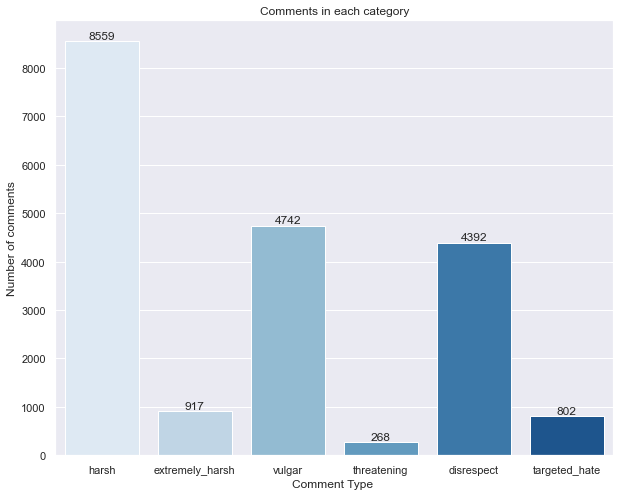

In [18]:
sns.set(font_scale = 1)
plt.figure(figsize=(10,8))

ax= sns.barplot(categories, data.iloc[:,2:].sum().values, palette = "Blues")

plt.title("Comments in each category", fontsize=12)
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Comment Type ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = data.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)

plt.show()

In [19]:
# Graph plot to visualize the comments having multiple labels

C:\Users\Asus\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


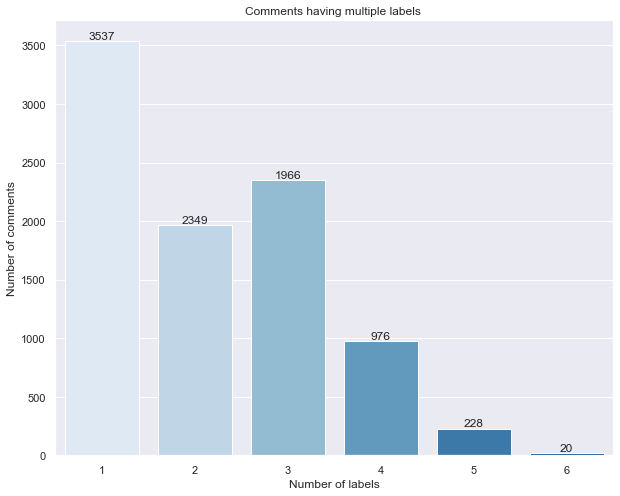

In [20]:
multiLabelCount = data.iloc[:,2:].sum(axis=1).value_counts()

multiLabelCount = multiLabelCount.iloc[1:]

sns.set(font_scale = 1)
plt.figure(figsize=(10,8))

ax = sns.barplot(multiLabelCount.index, multiLabelCount.values, palette = "Blues")

plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of labels', fontsize=12)

#adding the text labels
rects = ax.patches
labels = multiLabelCount.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 2, label, ha='center', va='bottom')

plt.show()

# Data PreProcessing

In [21]:
import string

# Data cleaning, it converts text data to lowercase, 
# removes html symbols newline whitespace numbers alphanumeric punctuations 

# at the end it cleans the data and we are left with only english words
def dataCleaning(text):
    text=text.lower()
    htmlre = re.compile('<.*?>') #html
    text = re.sub(htmlre, ' ', str(text))
    text = re.sub(r'(.)\1{2,}', r'\1', text) 
    text = str(text).replace("\n", " ") # new Line
    text = re.sub(r'[^\w\s]',' ',text) # whitespace
    text = re.sub('[0-9]',"",text) # numbers
    text = re.sub(" +", " ", text) # non english characters
    text = re.sub('\w*\d\w*', ' ', text) # alphanumeric
    # '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    # non ascii
    text = re.sub("([^\x00-\x7F])+"," ",text)
    return text 

In [22]:
data['text'] = data['text'].apply(dataCleaning)

In [23]:
test['text'] = test['text'].apply(dataCleaning)

In [24]:
data['text'][0]

' december utc i am interested not in arguing but in the policies which resolve our ongoing content dispute also see wikipedia wikiproject united states presidential elections for what i ll be working on also the moneybomb closer just self reverted on two different requests which echoed what i would have requested i will rephrase which i didn t see an answer to building on our agreement that moneybomb should not be a redlink given the deletion reversion what should be the outline of the article called moneybomb or should it be submitted for afd again in due time if the latter see the previous version of however this version will require a detailed answer because any ambiguity will only necessitate clarifying questions '

In [25]:
# separating columns in a specific data set for each label

data_harsh = data.loc[:,['id','text','harsh']]
data_extremely_harsh = data.loc[:,['id','text','extremely_harsh']]
data_vulgar = data.loc[:,['id','text','vulgar']]
data_threatening = data.loc[:,['id','text','threatening']]
data_disrespect = data.loc[:,['id','text','disrespect']]
data_targeted_hate = data.loc[:,['id','text','targeted_hate']]

In [26]:
print(data_harsh.harsh.value_counts())
print(data_extremely_harsh.extremely_harsh.value_counts())
print(data_vulgar.vulgar.value_counts())
print(data_threatening.threatening.value_counts())
print(data_disrespect.disrespect.value_counts())
print(data_targeted_hate.targeted_hate.value_counts())

0    80800
1     8559
Name: harsh, dtype: int64
0    88442
1      917
Name: extremely_harsh, dtype: int64
0    84617
1     4742
Name: vulgar, dtype: int64
0    89091
1      268
Name: threatening, dtype: int64
0    84967
1     4392
Name: disrespect, dtype: int64
0    88557
1      802
Name: targeted_hate, dtype: int64


In [27]:
wordnetlemmatizer = WordNetLemmatizer()

In [28]:
# function to perform lemmatization 
# it removes noun verb adjective and adverb and converts to meaningful base word

def lemmatize(text):
    output=""
    text=text.split(" ")
    for word in text:
        word1 = wordnetlemmatizer.lemmatize(word, pos = "n") #noun
        word2 = wordnetlemmatizer.lemmatize(word1, pos = "v") #verb
        word3 = wordnetlemmatizer.lemmatize(word2, pos = "a") # adjective
        word4 = wordnetlemmatizer.lemmatize(word3, pos = "r") #adverb
        output=output + " " + word4
  
    return str(output.strip()) 

# Removing stop words

In [29]:

stopWords = set(stopwords.words('english'))

stopWords.update(['december','january','february','march','april','may','june','august','september','october','november','july','please','within','good','know','thank','may','maybe','also','find','like','thing','time','want','around','would','below','across','among','beside','see','however','yet'])

def removeStopWords(text):
    text = ' '.join(word for word in text.split() if word not in stopWords)
    return text

data['text'] = data['text'].apply(removeStopWords)
test['text'] = test['text'].apply(removeStopWords)

# Balancing data cols 

In [30]:
# trying to minimize the data in such a way that the ratio between 1s and 0s are at least 50:50 and if data for 1s is lesser then 20:80

data_harsh_true = data_harsh[data_harsh['harsh'] == 1].iloc[0:5000,:]
data_harsh_false = data_harsh[data_harsh['harsh'] == 0].iloc[0:5000,:]
data_harsh_set = pd.concat([data_harsh_true, data_harsh_false], axis=0)
data_harsh_set.shape

(10000, 3)

In [31]:
data_extremely_harsh_true = data_extremely_harsh[data_extremely_harsh['extremely_harsh'] == 1].iloc[0:917,:]
data_extremely_harsh_false = data_extremely_harsh[data_extremely_harsh['extremely_harsh'] == 0].iloc[0:917,:]
data_extremely_harsh_set = pd.concat([data_extremely_harsh_true, data_extremely_harsh_false], axis=0)
data_extremely_harsh_set.shape

(1834, 3)

In [32]:
data_vulgar_true = data_vulgar[data_vulgar['vulgar'] == 1].iloc[0:4742,:]
data_vulgar_false = data_vulgar[data_vulgar['vulgar'] == 0].iloc[0:4742,:]
data_vulgar_set = pd.concat([data_vulgar_true, data_vulgar_false], axis=0)
data_vulgar_set.shape

(9484, 3)

In [33]:
data_threatening_true = data_threatening[data_threatening['threatening'] == 1].iloc[0:268,:]
# We include 1072 comments that have no threat so that the data with threat (268) will represent 20% of the dataset.
data_threatening_false = data_threatening[data_threatening['threatening'] == 0].iloc[0:1072,:]  
data_threatening_set = pd.concat([data_threatening_true, data_threatening_false], axis=0)
data_threatening_set.shape

(1340, 3)

In [34]:
data_disrespect_true = data_disrespect[data_disrespect['disrespect'] == 1].iloc[0:4392,:]
data_disrespect_false = data_disrespect[data_disrespect['disrespect'] == 0].iloc[0:4392,:]
data_disrespect_set = pd.concat([data_disrespect_true, data_disrespect_false], axis=0)
data_disrespect_set.shape

(8784, 3)

In [35]:
data_targeted_hate_true = data_targeted_hate[data_targeted_hate['targeted_hate'] == 1].iloc[0:802,:] # 20%
data_targeted_hate_false = data_targeted_hate[data_targeted_hate['targeted_hate'] == 0].iloc[0:3208,:] # 80%
data_targeted_hate_set = pd.concat([data_targeted_hate_true, data_targeted_hate_false], axis=0)
data_targeted_hate_set.shape

(4010, 3)

# model fitting

In [36]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import CalibratedClassifierCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [43]:
def cv_tf_train_test(dframe,colmns,vectorizer,ngram):
    x = dframe.text
    y = dframe[colmns]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    tfv = vectorizer(ngram_range=(ngram), stop_words='english')
    x_train_tfv = tfv.fit_transform(x_train)
    x_test_tfv  = tfv.transform(x_test) 
    uk_test_fit = tfv.transform(test['text'])
    lr = LogisticRegression()
    lr.fit(x_train_tfv, y_train)
    uk_prob = lr.predict_proba(uk_test_fit)
    mnb = MultinomialNB()
    mnb.fit(x_train_tfv, y_train)
    f1_score_data = {'F1 Score':[f1_score(lr.predict(x_test_tfv), y_test), f1_score(mnb.predict(x_test_tfv), y_test)]} 
    df_f1 = pd.DataFrame(f1_score_data, index=['Logistic Regression', 'MultinomialNB'])  
    return df_f1,uk_prob

In [44]:
cols=['harsh', 'extremely_harsh', 'vulgar', 'threatening','disrespect', 'targeted_hate']
dones=[data_harsh_set,data_extremely_harsh_set,data_vulgar_set,data_threatening_set,data_disrespect_set,data_targeted_hate_set]
cvs=[]
probs={}
for i in range(len(cols)):    
    print("***",cols[i],"***")
    ans=cv_tf_train_test(dones[i],cols[i], TfidfVectorizer, (1,1))
    cvs.append(ans[0])
    probs[cols[i]]=ans[1]
    cvs[i].rename(columns={'F1 Score': 'F1 Score'}, inplace=True)


cvs

*** harsh ***
*** extremely_harsh ***
*** vulgar ***
*** threatening ***
*** disrespect ***
*** targeted_hate ***


[                     F1 Score
 Logistic Regression  0.872876
 MultinomialNB        0.869856,
                      F1 Score
 Logistic Regression  0.914611
 MultinomialNB        0.929078,
                      F1 Score
 Logistic Regression  0.907028
 MultinomialNB        0.895543,
                      F1 Score
 Logistic Regression  0.560000
 MultinomialNB        0.594059,
                      F1 Score
 Logistic Regression  0.888889
 MultinomialNB        0.887115,
                      F1 Score
 Logistic Regression  0.652956
 MultinomialNB        0.425532]

In [45]:
probs

{'harsh': array([[0.48760455, 0.51239545],
        [0.2046168 , 0.7953832 ],
        [0.44967282, 0.55032718],
        ...,
        [0.55970162, 0.44029838],
        [0.01283952, 0.98716048],
        [0.89779761, 0.10220239]]),
 'extremely_harsh': array([[0.62711636, 0.37288364],
        [0.65724107, 0.34275893],
        [0.58968805, 0.41031195],
        ...,
        [0.70078714, 0.29921286],
        [0.10909876, 0.89090124],
        [0.82532377, 0.17467623]]),
 'vulgar': array([[0.68903902, 0.31096098],
        [0.56067921, 0.43932079],
        [0.55451917, 0.44548083],
        ...,
        [0.64702773, 0.35297227],
        [0.01110062, 0.98889938],
        [0.87421604, 0.12578396]]),
 'threatening': array([[0.81895059, 0.18104941],
        [0.81547253, 0.18452747],
        [0.81471916, 0.18528084],
        ...,
        [0.86377144, 0.13622856],
        [0.63711443, 0.36288557],
        [0.90750687, 0.09249313]]),
 'disrespect': array([[0.65580743, 0.34419257],
        [0.48154298, 0.